In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
mpl.rc('font',family='Serif')
import re
np.set_printoptions(precision=2)

In [28]:
def getCalibrationInfo(file):
    calibration = pd.read_csv(file, skiprows=20, names=['PitotVel', 'HotWireEv'])
    PitotVel = np.array(calibration['PitotVel'])
    Voltage = np.array(calibration['HotWireEv'])
    file_coeff = pd.read_csv('calibration_curve', skiprows=15, nrows=1)
    fixed_coeff = np.flip(np.array(file_coeff).reshape((5,)))
    return PitotVel, Voltage, fixed_coeff

def getVelocityProfile(file):
    return pd.read_csv(file, skiprows=16, names=['LateralPos', 'PitotVel', 'PitotVelStd', 'HotWireVel', 'HotWireVelStd'])

def computeInfo(frame, series):
    U = np.mean([frame[series][:3], frame[series][-3:]])
    y_0 = frame.loc[frame[series].idxmin(), 'LateralPos']
    Y = (frame['LateralPos'] - y_0) / 120
    return U, Y

def getTransient(file):
    return np.array(pd.read_excel(file, header=None, skiprows=1, engine='openpyxl'))

def computeFFT(file):
    data = getTransient(file).flatten('F')
    sp = np.fft.fft(data)
    freq = np.fft.fftfreq(len(data), 1/8000)
    domain = np.nonzero(freq > 0.)
    peak = freq[np.argmax(sp[domain])]
    return sp, freq, peak

def computeDynViscosity(T):
    """
    Returns dynamic viscosity determined by Sutherland's law
    """
    mu_ref = 1.716e-5
    T_ref = 273.15
    S = 110.4
    return mu_ref*(T/T_ref)**1.5*(T_ref + S)/(T + S)

def computeDragDiscrete(U, u, ax, rho, w):
    """
    Returns the drag force using momentum deficit method. 
    The integral is computed using a discrete method.
    """
    dy = ax[1:] - ax[0:-1]
    integrand = u * (U - u)
    h = (integrand[1:] + integrand[0:-1]) / 2
    return rho * w * np.sum(h * dy)

def computeTurbInt(frame, UP, UH):
    return frame['PitotVelStd'] / UP, frame['HotWireVelStd'] / UH

def computeWakeThickness(frame, UP, UH, y_ax, rtol=1e-2, atol=1e-3):
    uL0P = UP - 0.605*(UP - np.min(frame['PitotVel']))
    uL0H = UH - 0.605*(UH - np.min(frame['HotWireVel']))
    
    for vel in frame['PitotVel']:
        if np.isclose(uL0P, vel, rtol=rtol, atol=atol):
            L0P = y_ax[frame['PitotVel'].tolist().index(vel)]
    for vel in frame['HotWireVel']:
        if np.isclose(uL0H, vel, rtol=1e-2, atol=1e-3):
            L0H = y_ax[frame['HotWireVel'].tolist().index(vel)]
            
    return L0P, L0H

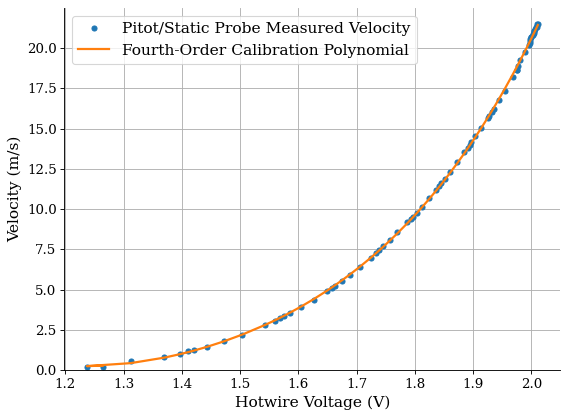

In [29]:
"""
Deliverable 2

"""
UP, EV, cal_coeff = getCalibrationInfo('calibration_curve')
figure(figsize=(8,6), dpi=80)
plt.plot(EV, UP, '.', markersize=9)
plt.plot(EV, np.polyval(cal_coeff, EV), linewidth=2)
plt.xlabel('Hotwire Voltage (V)', fontsize=14)
plt.ylabel('Velocity (m/s)', fontsize=14)
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim([0, UP[-1]+1])
plt.legend(['Pitot/Static Probe Measured Velocity', 'Fourth-Order Calibration Polynomial'], fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig('calibration.png')

In [30]:
"""
Deliverable 3

"""
VP_X1 = getVelocityProfile('velocity_profile_x1')
VP_X2 = getVelocityProfile('velocity_profile_x2')
VP_X2 = VP_X2.iloc[::2] # Trim T.A. data to 2 mm increments
VP_X3 = getVelocityProfile('velocity_profile_x3')
VP_X4 = getVelocityProfile('velocity_profile_x4')

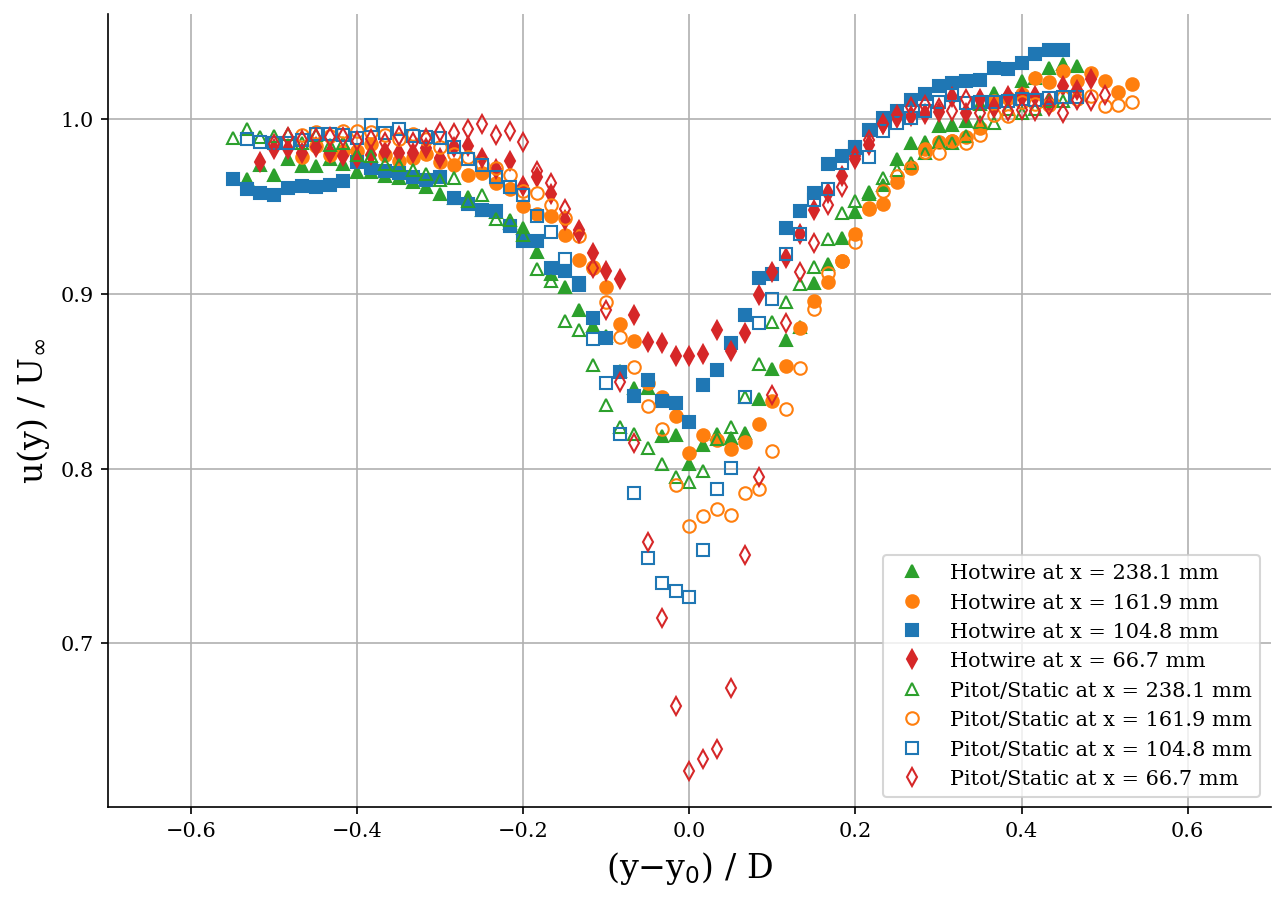

In [31]:
U1H, Y1H = computeInfo(VP_X1, 'HotWireVel')
U2H, Y2H = computeInfo(VP_X2, 'HotWireVel')
U3H, Y3H = computeInfo(VP_X3, 'HotWireVel')
U4H, Y4H = computeInfo(VP_X4, 'HotWireVel')
U1P, Y1P = computeInfo(VP_X1, 'PitotVel')
U2P, Y2P = computeInfo(VP_X2, 'PitotVel')
U3P, Y3P = computeInfo(VP_X3, 'PitotVel')
U4P, Y4P = computeInfo(VP_X4, 'PitotVel')

figure(figsize=(10,7), dpi=150)
plt.plot(Y1H, VP_X1['HotWireVel']/U1H, '^', color='tab:green', label='Hotwire at x = 238.1 mm')
plt.plot(Y2H, VP_X2['HotWireVel']/U2H, 'o', color='tab:orange', label='Hotwire at x = 161.9 mm')
plt.plot(Y3H, VP_X3['HotWireVel']/U3H, 's', color='tab:blue', label='Hotwire at x = 104.8 mm')
plt.plot(Y4H, VP_X4['HotWireVel']/U4H, 'd', color='tab:red', label='Hotwire at x = 66.7 mm')
plt.plot(Y1P, VP_X1['PitotVel']/U1P, '^', color='tab:green', fillstyle='none', label='Pitot/Static at x = 238.1 mm')
plt.plot(Y2P, VP_X2['PitotVel']/U2P, 'o', color='tab:orange', fillstyle='none', label='Pitot/Static at x = 161.9 mm')
plt.plot(Y3P, VP_X3['PitotVel']/U3P, 's', color='tab:blue', fillstyle='none', label='Pitot/Static at x = 104.8 mm')
plt.plot(Y4P, VP_X4['PitotVel']/U4P, 'd', color='tab:red', fillstyle='none', label='Pitot/Static at x = 66.7 mm')
plt.xlabel('(y$-$y$_0$) / D', fontsize=16)
plt.ylabel('u(y) / U$_\infty$', fontsize=16)
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim([-0.7, 0.7])
plt.tick_params(labelsize=10)
plt.legend(fontsize=10, loc="lower right")
plt.savefig('mean_vel_x.png')

In [32]:
"""
Deliverable 5

"""
#### Reynolds number ###########################################
T = 21.5 + 273.15 # K
P = 98.5 * 1000 # Pa
R = 287 # J/kg-K

rho = P/R/T
U_inf = np.array([U1H, U2H, U3H, U4H, U1P, U2P, U3P, U4P]) # m/s
mu = computeDynViscosity(T)
D = 19.05/1000 # m
w = 300/1000 # m

Re = rho * U_inf * D / mu

#### Drag force ################################################
# Collect velocity profiles
u3 = [VP_X1['HotWireVel'], VP_X2['HotWireVel'], VP_X3['HotWireVel'], VP_X4['HotWireVel'], 
      VP_X1['PitotVel'], VP_X2['PitotVel'], VP_X3['PitotVel'], VP_X4['PitotVel']]
# Discrete y locations
y_ax = np.array(VP_X1['LateralPos']) / 1000
# Create list for drag force
F_D = np.zeros(len(U_inf))
# Compute drag force
for idx in range(len(U_inf)):
    F_D[idx] = (computeDragDiscrete(U_inf[idx], np.array(u3[idx]), y_ax, rho, w))

# Compute quantities for nondimensionalization 
q = 0.5 * rho * U_inf**2
A = w * D
# Compute C_D
C_D = F_D / q / A

#### Consolidate and present computations ######################
df3 = pd.DataFrame(np.vstack((Re, F_D, C_D)),
                   columns=['Profile 1 H', 'Profile 2 H', 'Profile 3 H', 'Profile 4 H',
                            'Profile 1 P', 'Profile 2 P', 'Profile 3 P', 'Profile 4 P'])
df3.insert(0, 'Parameter', ['Re', 'F_D', 'C_D'])
display(df3)

,Parameter,Profile 1 H,Profile 2 H,Profile 3 H,Profile 4 H,Profile 1 P,Profile 2 P,Profile 3 P,Profile 4 P
0,Re,23852.104613,23602.034853,22616.382155,24739.029526,22371.187842,21910.458180,22209.891832,22354.530068
1,F_D,0.917880,0.789038,0.645738,0.616417,0.824905,0.724944,0.678185,0.724544
2,C_D,0.720124,0.632228,0.563488,0.449556,0.735699,0.674025,0.613663,0.647155


In [33]:
"""
Deliverable 6

"""
TI_P1, TI_H1 = computeTurbInt(VP_X1, U1P, U1H)
TI_P2, TI_H2 = computeTurbInt(VP_X2, U2P, U2H)
TI_P3, TI_H3 = computeTurbInt(VP_X3, U3P, U3H)
TI_P4, TI_H4 = computeTurbInt(VP_X4, U4P, U4H)

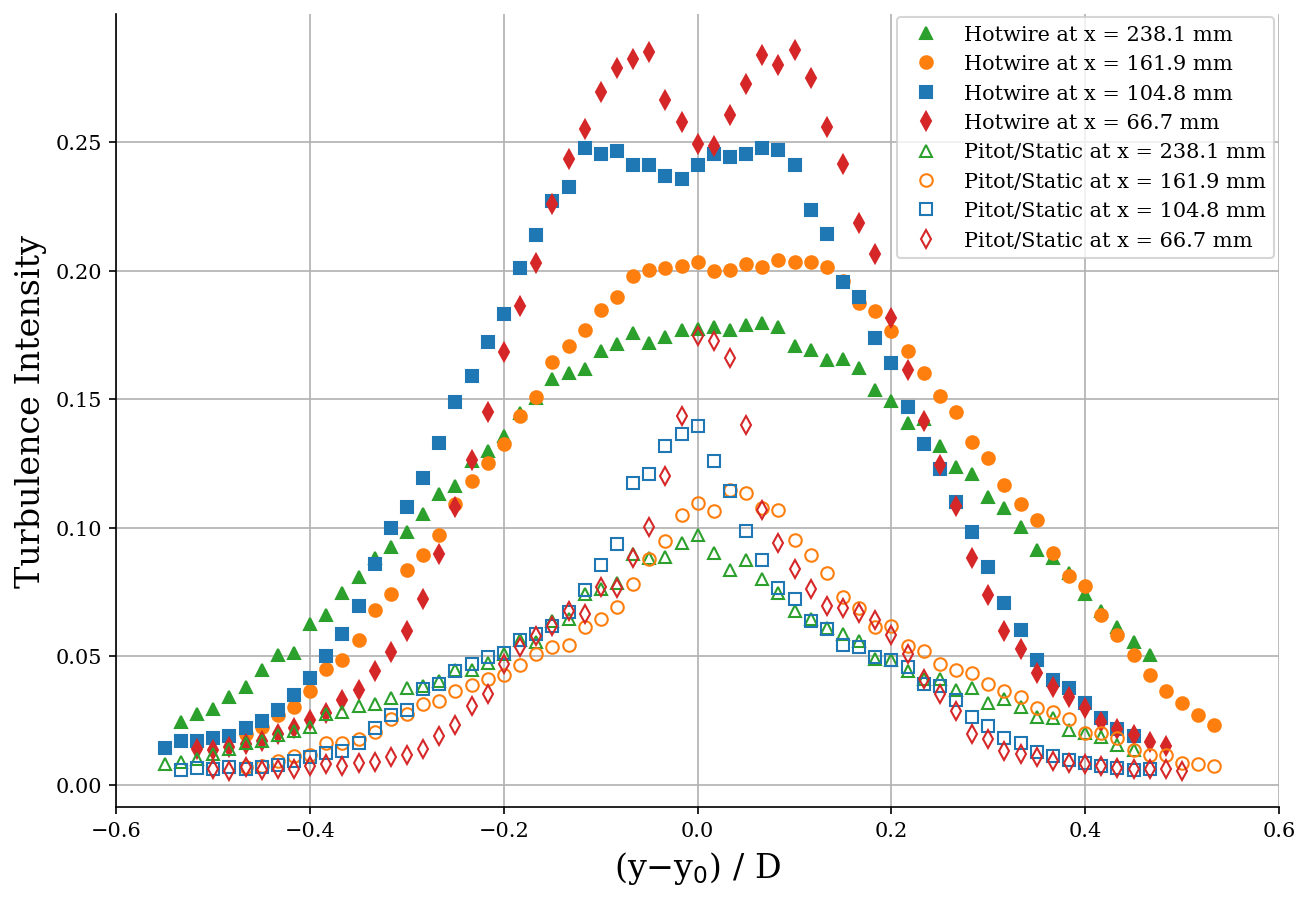

In [34]:
figure(figsize=(10,7), dpi=150)
plt.plot(Y1H, TI_H1, '^', color='tab:green', label='Hotwire at x = 238.1 mm')
plt.plot(Y2H, TI_H2, 'o', color='tab:orange', label='Hotwire at x = 161.9 mm')
plt.plot(Y3H, TI_H3, 's', color='tab:blue', label='Hotwire at x = 104.8 mm')
plt.plot(Y4H, TI_H4, 'd', color='tab:red', label='Hotwire at x = 66.7 mm')
plt.plot(Y1P, TI_P1, '^', color='tab:green', fillstyle='none', label='Pitot/Static at x = 238.1 mm')
plt.plot(Y2P, TI_P2, 'o', color='tab:orange', fillstyle='none', label='Pitot/Static at x = 161.9 mm')
plt.plot(Y3P, TI_P3, 's', color='tab:blue', fillstyle='none', label='Pitot/Static at x = 104.8 mm')
plt.plot(Y4P, TI_P4, 'd', color='tab:red', fillstyle='none', label='Pitot/Static at x = 66.7 mm')
plt.xlabel('(y$-$y$_0$) / D', fontsize=16)
plt.ylabel('Turbulence Intensity', fontsize=16)
plt.xlim([-0.6, 0.6])
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(labelsize=10)
plt.legend(fontsize=10, bbox_to_anchor=(1.005,1.01), loc="upper right")
plt.savefig('turb_intensity.png')

#### Large cylinder frequencies [Hz] ##################
FFT_10.xlsx: 96.25
FFT_13.xlsx: 128.59375
FFT_16.xlsx: 159.375
FFT_19.xlsx: 191.71875
FFT_22.xlsx: 213.90625
#### Small cylinder frequencies [Hz] ##################
FFT_10_S.xlsx: 147.5
FFT_13_S.xlsx: 203.28125
FFT_16_S.xlsx: 249.21875
FFT_19_S.xlsx: 292.96875
FFT_22_S.xlsx: 338.59375


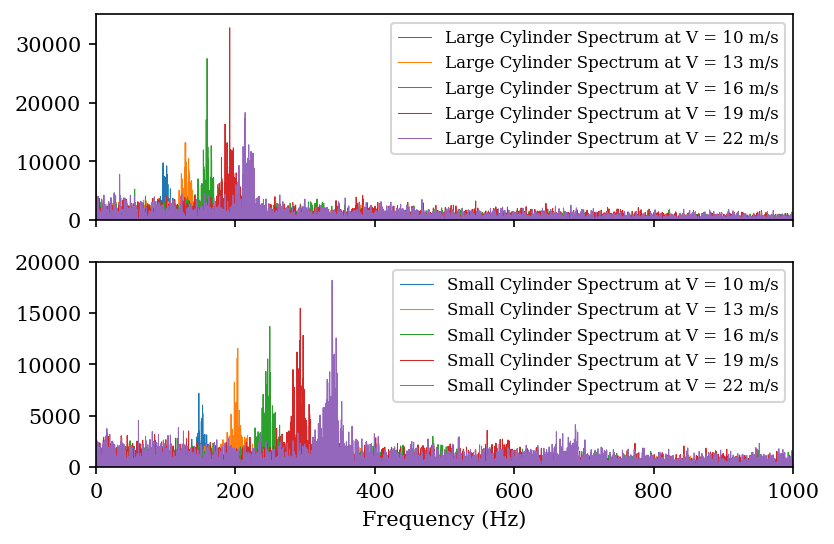

In [35]:
"""
Deliverables 7 and 8

"""
large_FFT_files = ['FFT_10.xlsx', 'FFT_13.xlsx', 'FFT_16.xlsx', 'FFT_19.xlsx', 'FFT_22.xlsx']
small_FFT_files = ['FFT_10_S.xlsx', 'FFT_13_S.xlsx', 'FFT_16_S.xlsx', 'FFT_19_S.xlsx', 'FFT_22_S.xlsx']
peaks = []
#### Large cylinder ##################################################
print('#### Large cylinder frequencies [Hz] ##################')
fig, ax = plt.subplots(2, 1, figsize=(6, 4), dpi=150, sharex=True)
for file in large_FFT_files:
    sp, freq, peak = computeFFT(file)
    peaks.append(peak)
    print(file+':', peak)
    ax[0].plot(freq, sp.real, linewidth=0.5)
#### Small cylinder ##################################################
print('#### Small cylinder frequencies [Hz] ##################')
for file in small_FFT_files:
    sp, freq, peak = computeFFT(file)
    peaks.append(peak)
    print(file+':', peak)
    ax[1].plot(freq, sp.real, linewidth=0.5)

plt.setp(ax, xlim=(0, 1000))
ax[0].set_ylim((0, 35000))
ax[1].set_ylim((0, 20000))
ax[0].legend(['Large Cylinder Spectrum at V = 10 m/s', 'Large Cylinder Spectrum at V = 13 m/s', 'Large Cylinder Spectrum at V = 16 m/s', 'Large Cylinder Spectrum at V = 19 m/s', 'Large Cylinder Spectrum at V = 22 m/s'], fontsize=8)
ax[1].legend(['Small Cylinder Spectrum at V = 10 m/s', 'Small Cylinder Spectrum at V = 13 m/s', 'Small Cylinder Spectrum at V = 16 m/s', 'Small Cylinder Spectrum at V = 19 m/s', 'Small Cylinder Spectrum at V = 22 m/s'], fontsize=8)
plt.xlabel('Frequency (Hz)')
plt.savefig('FFT.png')

In [36]:
all_files = ''.join(large_FFT_files + small_FFT_files)
vels = [int(s) for s in re.findall(r'\d+', all_files)]
d = [19.05/1000]*5 + [12.70/1000]*5
St = np.array(peaks) * np.array(d) / np.array(vels)
print(St)

[0.18 0.19 0.19 0.19 0.19 0.19 0.2  0.2  0.2  0.2 ]


In [37]:
# Reynolds number calculation
T = 21.5 + 273.15 # K
P = 98.5 * 1000 # Pa
R = 287 # J/kg-K

rho = P/R/T
V = np.array([10, 13, 16, 19, 22]) # m/s
mu = computeDynViscosity(T)
D = [19.05/1000, 12.07/1000] # m
w = 300/1000 # m

Re_L = rho * V * D[0] / mu
Re_S = rho * V * D[1] / mu
print(Re_L)
print(Re_S)

[12188.62 15845.2  19501.78 23158.37 26814.95]
[ 7722.66 10039.45 12356.25 14673.05 16989.84]


In [39]:
# Wake Thickness
L01P, L01H = computeWakeThickness(VP_X1, U1P, U1H, y_ax)
L02P, L02H = computeWakeThickness(VP_X2, U2P, U2H, y_ax)
L03P, L03H = computeWakeThickness(VP_X3, U3P, U3H, y_ax)
L04P, L04H = computeWakeThickness(VP_X4, U4P, U4H, y_ax, rtol=1e-1)

In [40]:
L04P

0.012

In [41]:
L04H

0.016